# Práctica 2: Extracción de Biomarcadores de Imagen

In [1]:
!pip install pydicom nibabel numpy matplotlib scipy

  Using cached pydicom-2.4.4-py3-none-any.whl (1.8 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 39.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 16.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 119.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.4/232.4 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 8.0 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.0 MB/s eta 0:00:00a 0:00:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 14.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import os
import glob
import pydicom
import datetime
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [3]:
# Rutas
DWI_FOLDER = 'case_practica2/DWI'

DCE_FOLDER = 'case_practica2/DCE'
DCE_NIFTI_IMAGE = 'case_practica2/DCE/image.nii'
DCE_NIFTI_MASK = 'case_practica2/Masks/Mask_DCE.nii'

# Parte 1: Mapas de ADC
Carga la serie de archivos DICOM DWI del paciente `case_practica2`:

In [6]:
# Lista de archivos DICOM en la carpeta
dicom_files = []
for file in os.listdir(DWI_FOLDER):
    if file.endswith('.dcm'):
        dicom_files.append(os.path.join(DWI_FOLDER, file))

# Leer los archivos DICOM
slices = []
for filepath in dicom_files:
    dicom_data = pydicom.dcmread(filepath)
    slices.append(dicom_data)

print(f'Longitud de la serie: {len(slices)}')

Longitud de la serie: 120


a)	Extrae y muestra los valores b presentes en la serie.

In [7]:
b_values = [ds[0x0019, 0x100c].value for ds in slices]
b_values_list = list(np.unique(b_values))
print(f'Número de valores B: {len(b_values)} --> {b_values_list}')

Número de valores B: 120 --> [0, 150, 400, 1000]


b)	Ordena las imágenes y sus correspondientes valores b en orden ascendente.

In [8]:
# Función que carga y ordena directamente la serie
def load_and_sort_dicom_series(dicom_folder_path):
    dicom_files = glob.glob(os.path.join(dicom_folder_path, "*.dcm"))

    b_values_list = []
    images_list = []
    for f_path in dicom_files:
        ds = pydicom.dcmread(f_path)
        b_value = ds[0x0019, 0x100c].value
        pixel_array = ds.pixel_array

        b_values_list.append(float(b_value))
        images_list.append(pixel_array)

    b_values_np = np.array(b_values_list)
    dwi_images_np = np.stack(images_list, axis=0)

    # Ordenar por valor b
    sort_indices = np.argsort(b_values_np)
    b_values_sorted = b_values_np[sort_indices]
    dwi_images_sorted = dwi_images_np[sort_indices, :, :]

    # Obtener valores b únicos y su cantidad
    unique_b_values = np.unique(b_values_sorted)
    num_b = len(unique_b_values)
    slices_per_b = len(b_values_sorted) // num_b

    # Reorganizar a (slices, alto, ancho, num_b)
    dwi_4d = np.zeros((slices_per_b, dwi_images_sorted.shape[1], dwi_images_sorted.shape[2], num_b), dtype=dwi_images_sorted.dtype)
    for i, b in enumerate(unique_b_values):
        idx = np.where(b_values_sorted == b)[0]
        dwi_4d[:, :, :, i] = dwi_images_sorted[idx, :, :]

    print("Valores b cargados y ordenados:", list(unique_b_values))
    print("Dimensiones del array 4D:", dwi_4d.shape)

    return dwi_4d

dwi_images_sorted = load_and_sort_dicom_series(DWI_FOLDER)

Valores b cargados y ordenados: [0.0, 150.0, 400.0, 1000.0]
Dimensiones del array 4D: (30, 192, 192, 4)


c)	Obtén el mapa de ADC aplicando un ajuste monoexponencial a cada uno de los vóxeles.

In [9]:
def monoExp(b_values, S0, ADC):
    """Modelo monoexponencial S(b) = S0 * exp(-b * ADC)."""
    S0 = np.maximum(1e-9, S0)  # Evitar S0 <= 0
    ADC = np.maximum(0, ADC)   # ADC debe ser no-negativo

    return S0 * np.exp(-b_values * ADC)

def calculate_adc_map(dwi_images):
    """
    Calcula el mapa de ADC 3D para un array DWI 4D de forma (120, 192, 192, 4).
    Cada última dimensión corresponde a los 4 valores b ordenados.

    Args:
        dwi_images (numpy.ndarray): Array 4D con forma (120, 192, 192, 4).

    Returns:
        numpy.ndarray: Mapa de ADC 3D con forma (120, 192, 192).
    """

    # Los valores b se asumen fijos y conocidos
    b_values = np.array([0, 150, 400, 1000], dtype=np.float64)

    num_slices, height, width, num_b_values = dwi_images.shape
    adc_map = np.zeros((num_slices, height, width), dtype=np.float32)

    max_intensity_global = np.max(dwi_images) if dwi_images.size > 0 else 10000
    bounds = ([0, 0], [max_intensity_global * 2, 0.01])

    num_fit_failures = 0
    total_voxels = num_slices * height * width

    print(f"Procesando {total_voxels} voxels...")

    for s in range(num_slices):
        if s % max(1, num_slices // 10) == 0:
            print(f"Procesando slice {s+1}/{num_slices}...")
        for r in range(height):
            for c in range(width):
                pixel_intensities = dwi_images[s, r, c, :].astype(np.float64)
                valid_indices = pixel_intensities > 1e-9
                current_b_values = b_values[valid_indices]
                current_intensities = pixel_intensities[valid_indices]

                if len(current_b_values) < 2:
                    adc_map[s, r, c] = 0.0
                    num_fit_failures += 1
                    continue

                s0_guess = np.max(current_intensities)
                adc_guess = 0.001
                p0 = [s0_guess, adc_guess]

                try:
                    popt, _ = curve_fit(
                        monoExp,
                        current_b_values,
                        current_intensities,
                        p0=p0,
                        bounds=bounds,
                        maxfev=500
                    )
                    fitted_adc = popt[1]
                    if np.isnan(fitted_adc) or np.isinf(fitted_adc) or fitted_adc < 0:
                        adc_map[s, r, c] = 0.0
                        num_fit_failures += 1
                    else:
                        adc_map[s, r, c] = fitted_adc
                except Exception:
                    adc_map[s, r, c] = 0.0
                    num_fit_failures += 1

    if num_fit_failures > 0:
        print(f"Advertencia: El ajuste falló para {num_fit_failures}/{total_voxels} voxels ({100*num_fit_failures/total_voxels:.1f}%).")
    print("Cálculo de ADC 3D finalizado.")
    return adc_map

adc_calculated_map = calculate_adc_map(dwi_images_sorted)
print(adc_calculated_map.shape)

Procesando 1105920 voxels...
Procesando slice 1/30...


/Users/mauriciodeoliveirareis/.pyenv/versions/bioinformatics_py_3_8/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Procesando slice 4/30...
Procesando slice 7/30...
Procesando slice 10/30...
Procesando slice 13/30...
Procesando slice 16/30...
Procesando slice 19/30...
Procesando slice 22/30...
Procesando slice 25/30...
Procesando slice 28/30...
Advertencia: El ajuste falló para 106855/1105920 voxels (9.7%).
Cálculo de ADC 3D finalizado.
(30, 192, 192)


d) Visualiza el corte central superponiendo la imagen con valor b=0 en escala de grises y superponlo con el mapa de ADC.

Visualizando corte 3/30


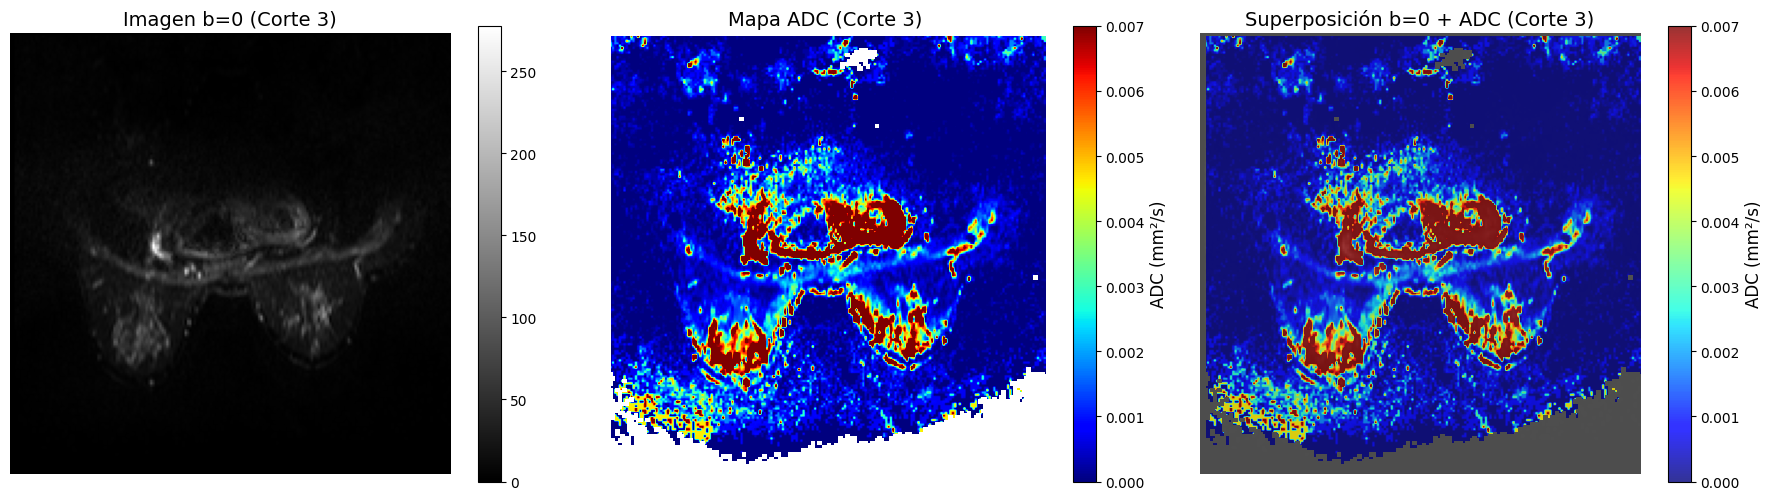


Estadísticas del corte 3:
Imagen b=0 - Min: 0.0, Max: 278.0, Media: 10.6
ADC válidos - Min: 0.000000, Max: 0.010000, Media: 0.001171
Porcentaje de voxels con ADC válido: 89.3%


In [10]:
def visualize_adc_overlay(dwi_images, adc_map, slice_idx=None, save_path=None):
    """
    Visualiza el corte central superponiendo la imagen b=0 con el mapa ADC.
    
    Args:
        dwi_images: Array original (120, 192, 192)
        adc_map: Mapa ADC calculado (30, 192, 192)
        slice_idx: Índice del corte a visualizar (None para el central)
    """
    
    # Obtener dimensiones
    adc_slices, _, _ = adc_map.shape
    
    # Determinar el corte a visualizar
    if slice_idx is None:
        slice_idx = adc_slices // 2  # Corte central
    
    print(f"Visualizando corte {slice_idx + 1}/{adc_slices}")
    
    # Extraer imagen b=0 (primeros 30 cortes)
    b0_image = dwi_images[slice_idx, :, :, 0]  # Corte correspondiente en b=0
    
    # Extraer mapa ADC para el mismo corte
    adc_slice = adc_map[slice_idx, :, :]
    
    # Crear máscara para valores ADC válidos (no cero)
    adc_mask = adc_slice > 0
    
    # Configurar la figura
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Imagen b=0 en escala de grises
    im1 = axes[0].imshow(b0_image, cmap='gray', origin='lower')
    axes[0].set_title(f'Imagen b=0 (Corte {slice_idx + 1})', fontsize=14)
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], shrink=0.8)
    
    # 2. Mapa ADC solo
    # Crear colormap personalizado para ADC
    adc_cmap = plt.cm.jet
    adc_display = np.where(adc_mask, adc_slice, np.nan)
    
    im2 = axes[1].imshow(adc_display, cmap=adc_cmap, origin='lower', 
                        vmin=0, vmax=np.percentile(adc_slice[adc_mask], 95) if np.any(adc_mask) else 0.003)
    axes[1].set_title(f'Mapa ADC (Corte {slice_idx + 1})', fontsize=14)
    axes[1].axis('off')
    cbar2 = plt.colorbar(im2, ax=axes[1], shrink=0.8)
    cbar2.set_label('ADC (mm²/s)', fontsize=12)
    
    # 3. Superposición
    # Normalizar imagen b=0 para mejor contraste
    b0_normalized = (b0_image - np.min(b0_image)) / (np.max(b0_image) - np.min(b0_image))
    
    # Mostrar imagen b=0 como fondo
    axes[2].imshow(b0_normalized, cmap='gray', origin='lower', alpha=0.7)
    
    # Superponer mapa ADC con transparencia
    adc_overlay = np.where(adc_mask, adc_slice, np.nan)
    im3 = axes[2].imshow(adc_overlay, cmap=adc_cmap, origin='lower', alpha=0.8,
                        vmin=0, vmax=np.percentile(adc_slice[adc_mask], 95) if np.any(adc_mask) else 0.003)
    
    axes[2].set_title(f'Superposición b=0 + ADC (Corte {slice_idx + 1})', fontsize=14)
    axes[2].axis('off')
    cbar3 = plt.colorbar(im3, ax=axes[2], shrink=0.8)
    cbar3.set_label('ADC (mm²/s)', fontsize=12)
    
    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    
    # Mostrar estadísticas
    print(f"\nEstadísticas del corte {slice_idx + 1}:")
    print(f"Imagen b=0 - Min: {np.min(b0_image):.1f}, Max: {np.max(b0_image):.1f}, Media: {np.mean(b0_image):.1f}")
    if np.any(adc_mask):
        valid_adc = adc_slice[adc_mask]
        print(f"ADC válidos - Min: {np.min(valid_adc):.6f}, Max: {np.max(valid_adc):.6f}, Media: {np.mean(valid_adc):.6f}")
        print(f"Porcentaje de voxels con ADC válido: {100 * np.sum(adc_mask) / adc_mask.size:.1f}%")
    else:
        print("No hay valores ADC válidos en este corte")

visualize_adc_overlay(dwi_images_sorted, adc_calculated_map, slice_idx=2)

# Parte 2: Parámetros Semi-Cuantitativos DCE
Carga la imagen DCE y su segmentación NifTI del paciente `case_practica3`. Adicionalmente, carga también su serie DICOM DCE:

In [11]:
# Carga de archivos Nifti
dce_img = nib.load(DCE_NIFTI_IMAGE)
mask_img = nib.load(DCE_NIFTI_MASK)

# Obtener datos como arrays
dce_data = dce_img.get_fdata()
mask_data = mask_img.get_fdata()

# Verificar dimensiones
print(f"Dimensiones de la serie DCE: {dce_data.shape}")
print(f"Dimensiones de la máscara: {mask_data.shape}")

Dimensiones de la serie DCE: (512, 256, 120, 6)
Dimensiones de la máscara: (512, 256, 120)


a)	Indica el número de dinámicos presentes (0.5 puntos).

In [12]:
print(f'Numero de dinámicos serie DCE: {dce_data.shape[-1]}')

Numero de dinámicos serie DCE: 6


b)	Obtén la resolución temporal (tiempo entre dinámicos) a partir de la serie DICOM. 

In [17]:
def get_time_resolution_from_dicom(dicom_series_path):
    """
    Calcula la resolución temporal (tiempo entre dinámicos)
    a partir de una serie de archivos DICOM.
    Retorna el tiempo en segundos (mediana de las diferencias) o None si falla.
    """

    dicom_files_paths = []
    for root, _, files in os.walk(dicom_series_path):
        for file in files:
            dicom_files_paths.append(os.path.join(root, file))

    acquisition_info = [] # Lista de tuplas (instance_number, acquisition_datetime)

    for f_path in dicom_files_paths:
        ds = pydicom.dcmread(f_path, stop_before_pixels=True, force=True)

        if 'InstanceNumber' not in ds or 'AcquisitionTime' not in ds:
                continue

        inst_num = int(ds.InstanceNumber)
        acq_time_str = ds.AcquisitionTime
        
        # La fecha es crucial si la adquisición cruza la medianoche.
        # Intentar con AcquisitionDate, luego SeriesDate, luego StudyDate.
        acq_date_str = ds.get('AcquisitionDate', ds.get('SeriesDate', ds.get('StudyDate', '')))

        # Construir el string completo de fecha y hora
        datetime_str = acq_date_str + acq_time_str
        
        try:
            dt_obj = datetime.datetime.strptime(datetime_str, '%Y%m%d%H%M%S.%f')
        except ValueError:
            try:
                dt_obj = datetime.datetime.strptime(datetime_str, '%Y%m%d%H%M%S')
            except ValueError as e_dt:
                # print(f"No se pudo parsear fecha/hora para {f_path}: {datetime_str} - Error: {e_dt}")
                continue
        
        acquisition_info.append({'instance': inst_num, 'time': dt_obj, 'path': f_path})

    # Agrupar por tiempo de adquisición para identificar dinámicos únicos
    unique_times = sorted(list(set(info['time'] for info in acquisition_info)))

    # Calcular las diferencias entre estos tiempos únicos
    time_diffs_seconds = []
    for i in range(len(unique_times) - 1):
        delta = unique_times[i+1] - unique_times[i]
        time_diffs_seconds.append(delta.total_seconds())

    # Usar la mediana para robustez
    calculated_tr_dicom = np.median(time_diffs_seconds)
    
    print(f"Tiempos de adquisición únicos encontrados: {len(unique_times)}")
    print(f"Diferencias de tiempo calculadas (segundos): {np.round(time_diffs_seconds, 4)}")
    print(f"Resolución temporal calculada desde DICOM (mediana): {calculated_tr_dicom:.4f} segundos")

    return calculated_tr_dicom

time_resolution = get_time_resolution_from_dicom(DCE_FOLDER)

Tiempos de adquisición únicos encontrados: 6
Diferencias de tiempo calculadas (segundos): [116.755   76.5925  76.595   76.5925  76.595 ]
Resolución temporal calculada desde DICOM (mediana): 76.5950 segundos


c)	Calcula la señal media para cada tiempo en la máscara y muestra el número de vóxeles total.

In [18]:
# Convertir máscara a booleana
mask_boolean = mask_data > 0.5 # Umbral > 0.5 para asegurar valores binarios (1)
print(f"Número de vóxeles en la ROI: {np.sum(mask_boolean)}")

Número de vóxeles en la ROI: 7166


In [19]:
# Extracción de la Curva de Intensidad Media en la ROI
num_time_points = dce_data.shape[3]
signal_roi = np.zeros(num_time_points)

# Calcular señal media para cada tiempo
signal_roi = dce_data[mask_boolean, :].mean(axis=0)

print(f"Curva de intensidad media en ROI extraída. Longitud: {len(signal_roi)}")
print(f"Valores de señal media en ROI: {np.round(signal_roi[:10], 2)}")

Curva de intensidad media en ROI extraída. Longitud: 6
Valores de señal media en ROI: [ 52.9  172.79 207.55 209.57 203.74 214.15]


d)	Calcula la señal basal (S0) en la ROI, suponiendo que el primer dinámico es el único pre-contraste.

In [20]:
n_baseline = 1    # Número de puntos temporales pre-contraste

# Cálculo señal basal (S0)
s0 = np.mean(signal_roi[:n_baseline])
print(f"Señal Basal (S0) calculada: {s0:.4f}")

Señal Basal (S0) calculada: 52.9036


e) Calcula el realce relativo usando la fórmula (0.5 puntos):

$$\text{Relative Enhancement (\%)} = \frac{S(t)-S(0)}{S(0)} \cdot 100$$


In [21]:
if np.isclose(s0, 0):
    print("Advertencia: La señal basal S0 es muy cercana a cero. El realce relativo puede ser inestable.")
    # Añadir un pequeño epsilon para evitar división por cero si se desea
    epsilon = 1e-9
    relative_enhancement = ((signal_roi - s0) / (s0 + epsilon)) * 100
else:
    relative_enhancement = ((signal_roi - s0) / s0) * 100

print(f"Vvalores de Realce Relativo (%): {np.round(relative_enhancement, 2)}")

Vvalores de Realce Relativo (%): [  0.   226.62 292.31 296.14 285.12 304.79]


f)	Calcula e imprime los siguientes parámetros semi-cuantitativos:
- Realce Pico (PE): Encuentra el valor máximo del realce relativo después de la fase de baseline. Expresa el resultado en porcentaje.
- Tiempo hasta el Pico (TTP): Encuentra el tiempo (en segundos) en el que ocurre el Realce Pico. Considera el tiempo relativo al inicio de la adquisición (t=0).
- Pendiente Máxima de Lavado (WIS): Calcula la máxima pendiente (realce por segundo) entre puntos consecutivos en la fase de lavado, definida desde el final de la baseline hasta el TTP.


In [22]:
# Crear array de tiempo
time_points_sec = np.arange(num_time_points) * time_resolution

# Considerar solo la parte post-baseline para PE, TTP, WIS
post_baseline_enhancement = relative_enhancement[n_baseline:]
post_baseline_time_indices = np.arange(n_baseline, num_time_points)
post_baseline_time_sec = time_points_sec[n_baseline:]

In [23]:
# Realce Pico (PE)
pe = np.max(post_baseline_enhancement)
pe_relative_index = np.argmax(post_baseline_enhancement)

# Tiempo hasta el Pico (TTP)
ttp_index = post_baseline_time_indices[pe_relative_index]
# Tiempo en segundos desde t=0
ttp_sec = time_points_sec[ttp_index]

# Pendiente Máxima de Lavado (WIS)
# Intervalo para WIS: desde n_baseline hasta ttp_index (inclusive)
washin_enhancement = relative_enhancement[n_baseline : ttp_index + 1]
# Calcular diferencias entre puntos consecutivos
slopes = np.diff(washin_enhancement) / time_resolution # %/segundos
wis = np.max(slopes)

In [24]:
print(f"Realce Pico (PE):               {pe:.2f} %")
print(f"Tiempo hasta el Pico (TTP):     {ttp_sec:.2f} s")
print(f"Pendiente Máxima Wash-in (WIS): {wis:.4f} %/s")

Realce Pico (PE):               304.79 %
Tiempo hasta el Pico (TTP):     382.98 s
Pendiente Máxima Wash-in (WIS): 0.8577 %/s
